# AI 07a CIFAR-10 (Kaggle)



---


## YCS1003 CIFAR-10 Competition 2021-2

CIFAR-10은 32x32픽셀의 컬러이미지(RGB) 60000개로 이루어져 있으며

( training set - 50000, test set - 10000 )

각 이미지는 10개의 클래스로 구분되어있습니다.


주어진 SimpleCNN 모델의 구조와 하이퍼파라미터를 변경하며 성능을 향상시켜보고

CIFAR-10 dataset에 대한 예측값을 생성한 후 제출하세요.

- Kaggle에는 .csv 파일을 submit 하고 (ranking 생성)
- LearnUs 과제란 에는 .ipynb 파일을 제출


**[중요] 반드시 SimpleCNN 클래스 내부를 변경하여 사용해야 하며**

**Pretrained 모델을 사용하거나 인터넷 복붙코드를 가져오지 마세요.**

**본인이 구조를 변경하며 다양하게 시도한 흔적이 보이도록 주석으로 남겨주세요.**



Kaggle에 .csv 파일을 제출할 때
먼저 Team 탭에서 팀이름을 자신의 분반, 학번, 실명으로 변경 후 제출하세요. (청강생의 경우 '청강'을 추가)

1. 01분반 201812345 김연세

2. 02분반 201912345 이세연 (청강)


### 점수 기준은 다음과 같습니다. (Test accuracy)

- 65% 미만: 4점
- 65% 이상: 6점
- 73% 이상: 7점 (+1)
- 80% 이상: 8점 (+2)
- 87% 이상: 9점 (+3)
- 90% 이상: 10점 (+4)
- Pretrained 모델 등 주어진 SimpleCNN를 변경하는 방식이 아닌 경우: 2점
- 복붙 코드 등 Cheating: -5점
- 늦은 제출: 0점
- Competition에 제출하지 않고 LearnUs에만 제출: 0점


### Import packages
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import pickle


### Setup a device

In [ ]:
# Device configuration

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


### Progress monitor
---

In [ ]:
from IPython.display import HTML, display


# Custom IPython progress bar for training
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

### Load the datasets
---

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform = T.Compose( [T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] )

train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform )
test_set = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform )



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(train_set.data.shape)
print(test_set.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Preview the data 
---

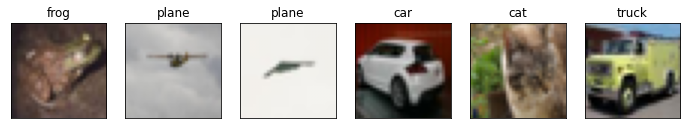

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

temp_loader = torch.utils.data.DataLoader(train_set, batch_size=30, shuffle=True)

dataiter = iter(temp_loader)
images, labels = dataiter.next()

images = images[:6]
labels = labels[:6]

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

### Specify a model architecture
---


In [ ]:
# [ conv_layers 변경 예 1 ]

# self.conv_layers = nn.Sequential(
    
#     nn.Conv2d( in_channels=3, out_channels=32, kernel_size=3, padding=1 ), # 3, 32x32 -> 32, 32x32
#     nn.BatchNorm2d(32),
#     nn.ReLU(),
#     nn.MaxPool2d(2), # 32, 32x32 -> 32, 16x16

#     nn.Conv2d( in_channels=32, out_channels=64, kernel_size=3, padding=1 ), # 32, 16x16 -> 64, 16x16
#     nn.BatchNorm2d(64),
#     nn.ReLU(),
#     nn.MaxPool2d(2), # 64, 16x16 -> 64, 8x8

# }


In [ ]:
# [Trial 1]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=3, padding=1 ), # 3, 32x32 -> 32, 32x32
#             nn.ReLU()
# batch_size = 1000, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 49.52  --> out_channels 늘리기

# [Trial 2]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=64, kernel_size=3, padding=1 ), # 3, 32x32 -> 64, 32x32
#             nn.ReLU(),
# batch_size = 1000, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 51.91% --> out_channels 더 늘려보기

# [Trial 3]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=128, kernel_size=3, padding=1 ), # 3, 32x32 -> 128, 32x32
#             nn.ReLU(),
# batch_size = 1000, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 53.14% --> kernal_size 늘려보기

# [Trial 4]
# self.conv_layers = nn.Sequential(
#     nn.Conv2d( in_channels=3, out_channels=128, kernel_size=5, padding=2 ), # 3, 32x32 -> 128, 32x32
#     nn.ReLU(),
# batch_size = 1000, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 55.41% --> 층수 늘리기

# [Trial 5]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 32x32 -> 64, 32x32
#             nn.ReLU(),
# batch_size = 1000, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 53.73% --> 층수 늘리기

# [Trial 6]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 32x32 -> 64, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 32x32 -> 64, 32x32
#             nn.ReLU()
# batch_size = 1000, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 55.38% --> 층수 늘리기

# [Trial 7]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 32x32 -> 64, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 32x32 -> 64, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=64, out_channels=128, kernel_size=5, padding=2 ), # 64, 32x32 -> 128, 32x32
#             nn.ReLU()
# batch_size = 1000, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 52.57% --> 층수 줄이고 out_channels 늘리기

# [Trial 8]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=64, kernel_size=5, padding=2 ), # 3, 32x32 -> 64, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 32x32 -> 64, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=64, out_channels=128, kernel_size=5, padding=2 ), # 64, 32x32 -> 128, 32x32
#             nn.ReLU()
# batch_size = 1000, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 54.01% --> out_channels 다시 줄이고 learning_rate 줄이기

# [Trial 9]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 32x32 -> 64, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 32x32 -> 64, 32x32
#             nn.ReLU()
# batch_size = 1000, learning_rate = 0.001, num_epochs = 20
# --> test accuracy: 35.83% --> batch_size 줄이기

# [Trial 10]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 32x32 -> 64, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 32x32 -> 64, 32x32
#             nn.ReLU()
# batch_size = 100, learning_rate = 0.001, num_epochs = 20
# --> test accuracy: 55.48% --> learning_rate 늘리기

# [Trial 11]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 32x32 -> 64, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 32x32 -> 64, 32x32
#             nn.ReLU()
# batch_size = 100, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 68.56% --> batch_size 줄이기

# [Trial 12]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 32x32 -> 64, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 32x32 -> 64, 32x32
#             nn.ReLU()
# batch_size = 50, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 70.1% --> batch_size 줄이기

# [Trial 13]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 32x32 -> 64, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 32x32 -> 64, 32x32
#             nn.ReLU()
# batch_size = 10, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 70.78% --> dropout 넣어보기

# [Trial 14]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 32x32 -> 64, 32x32
#             nn.ReLU(),
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 32x32 -> 64, 32x32
#             nn.ReLU(),
#             nn.Dropout()
# batch_size = 10, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 72.93% --> dropout 넣어보기

# [Trial 15]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.Dropout(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 32x32 -> 64, 32x32
#             nn.ReLU(),
#             nn.Dropout(),
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 32x32 -> 64, 32x32
#             nn.ReLU(),
#             nn.Dropout()
# batch_size = 10, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 74.06% --> maxpooling 넣어보기

# [Trial 16]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.MaxPool2d(2), #32, 32x32 -> 32, 16x16
#             nn.Dropout(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 16x16 -> 64, 16x16
#             nn.ReLU(),
#             nn.MaxPool2d(2), #64, 16x16 -> 64, 8x8
#             nn.Dropout(),
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 8x8 -> 64, 8x8
#             nn.ReLU(),
#             nn.MaxPool2d(2), #64, 8x8 -> 64, 4x4
#             nn.Dropout()
# batch_size = 10, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 74.70% --> Conv2d 층 늘리기

# [Trial 17]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.Conv2d( in_channels=32, out_channels=32, kernel_size=5, padding=2 ), # 32, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.MaxPool2d(2), #32, 32x32 -> 32, 16x16
#             nn.Dropout(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 16x16 -> 64, 16x16
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 16x16 -> 64, 16x16
#             nn.ReLU(),
#             nn.MaxPool2d(2), #64, 16x16 -> 64, 8x8
#             nn.Dropout(),
#             nn.Conv2d( in_channels=64, out_channels=128, kernel_size=5, padding=2 ), # 64, 8x8 -> 128, 8x8
#             nn.Conv2d( in_channels=128, out_channels=128, kernel_size=5, padding=2 ), # 128, 8x8 -> 128, 8x8
#             nn.ReLU(),
#             nn.MaxPool2d(2), #128, 8x8 -> 128, 4x4
#             nn.Dropout()
# batch_size = 10, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 76.78% --> Conv2d 층 늘리기 & epoch 늘리기

# [Trial 18]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.Conv2d( in_channels=32, out_channels=32, kernel_size=5, padding=2 ), # 32, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.MaxPool2d(2), #32, 32x32 -> 32, 16x16
#             nn.Dropout(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 16x16 -> 64, 16x16
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 16x16 -> 64, 16x16
#             nn.ReLU(),
#             nn.MaxPool2d(2), #64, 16x16 -> 64, 8x8
#             nn.Dropout(),
#             nn.Conv2d( in_channels=64, out_channels=128, kernel_size=5, padding=2 ), # 64, 8x8 -> 128, 8x8
#             nn.Conv2d( in_channels=128, out_channels=128, kernel_size=5, padding=2 ), # 128, 8x8 -> 128, 8x8
#             nn.ReLU(),
#             nn.MaxPool2d(2), #128, 8x8 -> 128, 4x4
#             nn.Dropout(),
#             nn.Conv2d( in_channels=128, out_channels=256, kernel_size=5, padding=2 ), # 128, 4x4 -> 256, 4x4
#             nn.ReLU(),
#             nn.MaxPool2d(2), #256, 4x4 -> 256, 2x2
#             nn.Dropout()
# batch_size = 10, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 76.59% --> Batch size 늘리기

# [Trial 19]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.Conv2d( in_channels=32, out_channels=32, kernel_size=5, padding=2 ), # 32, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.MaxPool2d(2), #32, 32x32 -> 32, 16x16
#             nn.Dropout(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 16x16 -> 64, 16x16
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 16x16 -> 64, 16x16
#             nn.ReLU(),
#             nn.MaxPool2d(2), #64, 16x16 -> 64, 8x8
#             nn.Dropout(),
#             nn.Conv2d( in_channels=64, out_channels=128, kernel_size=5, padding=2 ), # 64, 8x8 -> 128, 8x8
#             nn.Conv2d( in_channels=128, out_channels=128, kernel_size=5, padding=2 ), # 128, 8x8 -> 128, 8x8
#             nn.ReLU(),
#             nn.MaxPool2d(2), #128, 8x8 -> 128, 4x4
#             nn.Dropout(),
#             nn.Conv2d( in_channels=128, out_channels=256, kernel_size=5, padding=2 ), # 128, 4x4 -> 256, 4x4
#             nn.ReLU(),
#             nn.MaxPool2d(2), #256, 4x4 -> 256, 2x2
#             nn.Dropout()
# batch_size = 50, learning_rate = 0.01, num_epochs = 20
# --> test accuracy: 76.06% --> Epoch 늘리기

# [Trial 20]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.Conv2d( in_channels=32, out_channels=32, kernel_size=5, padding=2 ), # 32, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.MaxPool2d(2), #32, 32x32 -> 32, 16x16
#             nn.Dropout(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 16x16 -> 64, 16x16
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 16x16 -> 64, 16x16
#             nn.ReLU(),
#             nn.MaxPool2d(2), #64, 16x16 -> 64, 8x8
#             nn.Dropout(),
#             nn.Conv2d( in_channels=64, out_channels=128, kernel_size=5, padding=2 ), # 64, 8x8 -> 128, 8x8
#             nn.Conv2d( in_channels=128, out_channels=128, kernel_size=5, padding=2 ), # 128, 8x8 -> 128, 8x8
#             nn.ReLU(),
#             nn.MaxPool2d(2), #128, 8x8 -> 128, 4x4
#             nn.Dropout(),
#             nn.Conv2d( in_channels=128, out_channels=256, kernel_size=5, padding=2 ), # 128, 4x4 -> 256, 4x4
#             nn.ReLU(),
#             nn.MaxPool2d(2), #256, 4x4 -> 256, 2x2
#             nn.Dropout()
# batch_size = 50, learning_rate = 0.01, num_epochs = 50
# --> test accuracy: 82.70% --> Epoch 늘리기

# [Trial 21]
# self.conv_layers = nn.Sequential(
#             nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
#             nn.Conv2d( in_channels=32, out_channels=32, kernel_size=5, padding=2 ), # 32, 32x32 -> 32, 32x32
#             nn.ReLU(),
#             nn.MaxPool2d(2), #32, 32x32 -> 32, 16x16
#             nn.Dropout(),
#             nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 16x16 -> 64, 16x16
#             nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 16x16 -> 64, 16x16
#             nn.ReLU(),
#             nn.MaxPool2d(2), #64, 16x16 -> 64, 8x8
#             nn.Dropout(),
#             nn.Conv2d( in_channels=64, out_channels=128, kernel_size=5, padding=2 ), # 64, 8x8 -> 128, 8x8
#             nn.Conv2d( in_channels=128, out_channels=128, kernel_size=5, padding=2 ), # 128, 8x8 -> 128, 8x8
#             nn.ReLU(),
#             nn.MaxPool2d(2), #128, 8x8 -> 128, 4x4
#             nn.Dropout(),
#             nn.Conv2d( in_channels=128, out_channels=256, kernel_size=5, padding=2 ), # 128, 4x4 -> 256, 4x4
#             nn.ReLU(),
#             nn.MaxPool2d(2), #256, 4x4 -> 256, 2x2
#             nn.Dropout()
# batch_size = 50, learning_rate = 0.01, num_epochs = 150
# --> test accuracy: 85.14% --> Learning_rate 줄이고 BatchNorm층 추가

# [Trial 22]
# self.conv_layers = nn.Sequential(
            # nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
            # nn.Relu(),
            # nn.BatchNorm2d(32),
            # nn.Conv2d( in_channels=32, out_channels=32, kernel_size=5, padding=2 ), # 32, 32x32 -> 32, 32x32
            # nn.ReLU(),
            # nn.BatchNorm2d(32),
            # nn.MaxPool2d(2), #32, 32x32 -> 32, 16x16
            # nn.Dropout(),

            # nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 16x16 -> 64, 16x16
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            # nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 16x16 -> 64, 16x16
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            # nn.MaxPool2d(2), #64, 16x16 -> 64, 8x8
            # nn.Dropout(),

            # nn.Conv2d( in_channels=64, out_channels=128, kernel_size=5, padding=2 ), # 64, 8x8 -> 128, 8x8
            # nn.ReLU(),
            # nn.BatchNorm2d(128),
            # nn.Conv2d( in_channels=128, out_channels=128, kernel_size=5, padding=2 ), # 128, 8x8 -> 128, 8x8
            # nn.ReLU(),
            # nn.BatchNorm2d(128),
            # nn.MaxPool2d(2), #128, 8x8 -> 128, 4x4
            # nn.Dropout(),

            # nn.Conv2d( in_channels=128, out_channels=256, kernel_size=5, padding=2 ), # 128, 4x4 -> 256, 4x4
            # nn.ReLU(),
            # nn.BatchNorm2d(256),
            # nn.MaxPool2d(2), #256, 4x4 -> 256, 2x2
            # nn.Dropout()
# batch_size = 50, learning_rate = 0.001, num_epochs = 150
# --> test accuracy: 85.23% --> num_epochs 늘리기

#[Trial 23]
# self.conv_layers = nn.Sequential(
            # nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
            # nn.Relu(),
            # nn.BatchNorm2d(32),
            # nn.Conv2d( in_channels=32, out_channels=32, kernel_size=5, padding=2 ), # 32, 32x32 -> 32, 32x32
            # nn.ReLU(),
            # nn.BatchNorm2d(32),
            # nn.MaxPool2d(2), #32, 32x32 -> 32, 16x16
            # nn.Dropout(),

            # nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 16x16 -> 64, 16x16
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            # nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 16x16 -> 64, 16x16
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            # nn.MaxPool2d(2), #64, 16x16 -> 64, 8x8
            # nn.Dropout(),

            # nn.Conv2d( in_channels=64, out_channels=128, kernel_size=5, padding=2 ), # 64, 8x8 -> 128, 8x8
            # nn.ReLU(),
            # nn.BatchNorm2d(128),
            # nn.Conv2d( in_channels=128, out_channels=128, kernel_size=5, padding=2 ), # 128, 8x8 -> 128, 8x8
            # nn.ReLU(),
            # nn.BatchNorm2d(128),
            # nn.MaxPool2d(2), #128, 8x8 -> 128, 4x4
            # nn.Dropout(),

            # nn.Conv2d( in_channels=128, out_channels=256, kernel_size=5, padding=2 ), # 128, 4x4 -> 256, 4x4
            # nn.ReLU(),
            # nn.BatchNorm2d(256),
            # nn.MaxPool2d(2), #256, 4x4 -> 256, 2x2
            # nn.Dropout()
# batch_size = 50, learning_rate = 0.001, num_epochs = 300
# --> test accuracy: 86.91% --> batch size 늘리기

#[Trial 24]
# self.conv_layers = nn.Sequential(
            # nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
            # nn.Relu(),
            # nn.BatchNorm2d(32),
            # nn.Conv2d( in_channels=32, out_channels=32, kernel_size=5, padding=2 ), # 32, 32x32 -> 32, 32x32
            # nn.ReLU(),
            # nn.BatchNorm2d(32),
            # nn.MaxPool2d(2), #32, 32x32 -> 32, 16x16
            # nn.Dropout(),

            # nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 16x16 -> 64, 16x16
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            # nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 16x16 -> 64, 16x16
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            # nn.MaxPool2d(2), #64, 16x16 -> 64, 8x8
            # nn.Dropout(),

            # nn.Conv2d( in_channels=64, out_channels=128, kernel_size=5, padding=2 ), # 64, 8x8 -> 128, 8x8
            # nn.ReLU(),
            # nn.BatchNorm2d(128),
            # nn.Conv2d( in_channels=128, out_channels=128, kernel_size=5, padding=2 ), # 128, 8x8 -> 128, 8x8
            # nn.ReLU(),
            # nn.BatchNorm2d(128),
            # nn.MaxPool2d(2), #128, 8x8 -> 128, 4x4
            # nn.Dropout(),

            # nn.Conv2d( in_channels=128, out_channels=256, kernel_size=5, padding=2 ), # 128, 4x4 -> 256, 4x4
            # nn.ReLU(),
            # nn.BatchNorm2d(256),
            # nn.MaxPool2d(2), #256, 4x4 -> 256, 2x2
            # nn.Dropout()
# batch_size = 64, learning_rate = 0.001, num_epochs = 300
# --> test accuracy: 86.51% --> learning_rate 늘리고 epoch 줄이기

#[Trial 25]
# self.conv_layers = nn.Sequential(
            # nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
            # nn.Relu(),
            # nn.BatchNorm2d(32),
            # nn.Conv2d( in_channels=32, out_channels=32, kernel_size=5, padding=2 ), # 32, 32x32 -> 32, 32x32
            # nn.ReLU(),
            # nn.BatchNorm2d(32),
            # nn.MaxPool2d(2), #32, 32x32 -> 32, 16x16
            # nn.Dropout(),

            # nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 16x16 -> 64, 16x16
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            # nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 16x16 -> 64, 16x16
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            # nn.MaxPool2d(2), #64, 16x16 -> 64, 8x8
            # nn.Dropout(),

            # nn.Conv2d( in_channels=64, out_channels=128, kernel_size=5, padding=2 ), # 64, 8x8 -> 128, 8x8
            # nn.ReLU(),
            # nn.BatchNorm2d(128),
            # nn.Conv2d( in_channels=128, out_channels=128, kernel_size=5, padding=2 ), # 128, 8x8 -> 128, 8x8
            # nn.ReLU(),
            # nn.BatchNorm2d(128),
            # nn.MaxPool2d(2), #128, 8x8 -> 128, 4x4
            # nn.Dropout(),

            # nn.Conv2d( in_channels=128, out_channels=256, kernel_size=5, padding=2 ), # 128, 4x4 -> 256, 4x4
            # nn.ReLU(),
            # nn.BatchNorm2d(256),
            # nn.MaxPool2d(2), #256, 4x4 -> 256, 2x2
            # nn.Dropout()
# batch_size = 64, learning_rate = 0.01, num_epochs = 200
# --> test accuracy: 87.51%


In [ ]:
# SimpleCNN의 구조를 변경

class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d( in_channels=3, out_channels=32, kernel_size=5, padding=2 ), # 3, 32x32 -> 32, 32x32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d( in_channels=32, out_channels=32, kernel_size=5, padding=2 ), # 32, 32x32 -> 32, 32x32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2), #32, 32x32 -> 32, 16x16
            nn.Dropout(),

            nn.Conv2d( in_channels=32, out_channels=64, kernel_size=5, padding=2 ), # 32, 16x16 -> 64, 16x16
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d( in_channels=64, out_channels=64, kernel_size=5, padding=2 ), # 64, 16x16 -> 64, 16x16
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), #64, 16x16 -> 64, 8x8
            nn.Dropout(),

            nn.Conv2d( in_channels=64, out_channels=128, kernel_size=5, padding=2 ), # 64, 8x8 -> 128, 8x8
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d( in_channels=128, out_channels=128, kernel_size=5, padding=2 ), # 128, 8x8 -> 128, 8x8
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2), #128, 8x8 -> 128, 4x4
            nn.Dropout(),

            nn.Conv2d( in_channels=128, out_channels=256, kernel_size=5, padding=2 ), # 128, 4x4 -> 256, 4x4
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2), #256, 4x4 -> 256, 2x2
            nn.Dropout()
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear( 256 * 2 * 2, 10 ), # 256 * 2 * 2 -> 10
        )
        
        
    def forward(self, x):

        x = self.conv_layers(x) 
        
        x = x.view( x.size(0), -1 ) # flatten

        x = self.fc_layers(x)

        return x

# shape test code
tmp = SimpleCNN()
dummy = torch.randn(7,3,32,32)
print(tmp(dummy).size())

torch.Size([7, 10])


### Hyperparameters
---


In [ ]:
batch_size = 64
learning_rate = 0.01
num_epochs = 200

### Setup the data loaders
---


In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)



### Instantiate the model
---

In [ ]:
model = SimpleCNN()

model.to(device)


SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (12): ReLU()
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.5, inpl

### Train the model
---


In [ ]:
# 변경 원하는 경우 변경 가능

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [ ]:
from statistics import mean 

def train(optimizer, model, num_epochs=10, first_epoch=1):
    
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []

    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('Epoch', epoch)

        # train phase
        model.train()

        # create a progress bar
        progress = ProgressMonitor(length=len(train_set))
        
        # keep track of predictions
        correct_train = 0

        batch_losses = []

        for batch, targets in train_loader:
            
            # Move the training data to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # clear previous gradient computation
            optimizer.zero_grad()

            # forward propagation
            outputs = model(batch)

            # calculate the loss
            loss = criterion(outputs, targets)

            # backpropagate to compute gradients
            loss.backward()

            # update model weights
            optimizer.step()

            batch_losses.append(loss.item())

            # accumulate correct count
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == targets.data)

            # update progress bar
            progress.update(batch.shape[0], mean(batch_losses) )
            
        
        train_losses.append( mean(batch_losses))


        # test phase
        model.eval()

        y_pred = []

        correct_test = 0

        # We don't need gradients for test, so wrap in 
        # no_grad to save memory
        with torch.no_grad():

            for batch, targets in test_loader:

                # Move the training batch to the GPU
                batch = batch.to(device)
                targets = targets.to(device)

                # forward propagation
                outputs = model(batch)

                # calculate the loss
                loss = criterion(outputs, targets)

                # save predictions
                y_pred.extend( outputs.argmax(dim=1).cpu().numpy() )

                # accumulate correct count
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == targets.data)
                

        # Calculate accuracy
        train_acc = correct_train.item() / train_set.data.shape[0]
        test_acc = correct_test.item() / test_set.data.shape[0]

        print('Training accuracy: {:.2f}%'.format(float(train_acc) * 100))
        print('Test accuracy: {:.2f}%\n'.format(float(test_acc) * 100))

    
    return train_losses, test_losses, y_pred

### Checkpointing
---

In [ ]:
train_losses, test_losses, y_pred = train(optimizer, model, num_epochs=num_epochs)

Epoch 1


Loss: 1.8288 50000 / 50000,50000


Training accuracy: 37.92%
Test accuracy: 42.54%

Epoch 2


Loss: 1.3447 50000 / 50000,50000


Training accuracy: 52.48%
Test accuracy: 56.44%

Epoch 3


Loss: 1.1183 50000 / 50000,50000


Training accuracy: 60.41%
Test accuracy: 55.81%

Epoch 4


Loss: 0.9862 50000 / 50000,50000


Training accuracy: 64.91%
Test accuracy: 63.69%

Epoch 5


Loss: 0.9001 50000 / 50000,50000


Training accuracy: 68.30%
Test accuracy: 70.36%

Epoch 6


Loss: 0.8275 50000 / 50000,50000


Training accuracy: 70.65%
Test accuracy: 72.84%

Epoch 7


Loss: 0.7748 50000 / 50000,50000


Training accuracy: 72.86%
Test accuracy: 75.71%

Epoch 8


Loss: 0.7428 50000 / 50000,50000


Training accuracy: 74.10%
Test accuracy: 77.33%

Epoch 9


Loss: 0.7028 50000 / 50000,50000


Training accuracy: 75.38%
Test accuracy: 76.10%

Epoch 10


Loss: 0.6690 50000 / 50000,50000


Training accuracy: 76.62%
Test accuracy: 76.47%

Epoch 11


Loss: 0.6409 50000 / 50000,50000


Training accuracy: 77.66%
Test accuracy: 75.39%

Epoch 12


Loss: 0.6158 50000 / 50000,50000


Training accuracy: 78.66%
Test accuracy: 78.74%

Epoch 13


Loss: 0.5935 50000 / 50000,50000


Training accuracy: 79.13%
Test accuracy: 79.34%

Epoch 14


Loss: 0.5739 50000 / 50000,50000


Training accuracy: 79.99%
Test accuracy: 79.76%

Epoch 15


Loss: 0.5530 50000 / 50000,50000


Training accuracy: 80.55%
Test accuracy: 80.86%

Epoch 16


Loss: 0.5401 50000 / 50000,50000


Training accuracy: 81.22%
Test accuracy: 81.81%

Epoch 17


Loss: 0.5218 50000 / 50000,50000


Training accuracy: 81.75%
Test accuracy: 80.27%

Epoch 18


Loss: 0.5089 50000 / 50000,50000


Training accuracy: 82.23%
Test accuracy: 80.92%

Epoch 19


Loss: 0.4887 50000 / 50000,50000


Training accuracy: 82.92%
Test accuracy: 80.83%

Epoch 20


Loss: 0.4793 50000 / 50000,50000


Training accuracy: 83.34%
Test accuracy: 81.86%

Epoch 21


Loss: 0.4660 50000 / 50000,50000


Training accuracy: 83.54%
Test accuracy: 82.67%

Epoch 22


Loss: 0.4529 50000 / 50000,50000


Training accuracy: 83.98%
Test accuracy: 82.62%

Epoch 23


Loss: 0.4447 50000 / 50000,50000


Training accuracy: 84.46%
Test accuracy: 81.77%

Epoch 24


Loss: 0.4300 50000 / 50000,50000


Training accuracy: 84.89%
Test accuracy: 83.19%

Epoch 25


Loss: 0.4249 50000 / 50000,50000


Training accuracy: 85.22%
Test accuracy: 82.08%

Epoch 26


Loss: 0.4108 50000 / 50000,50000


Training accuracy: 85.59%
Test accuracy: 83.24%

Epoch 27


Loss: 0.4029 50000 / 50000,50000


Training accuracy: 85.78%
Test accuracy: 81.74%

Epoch 28


Loss: 0.3957 50000 / 50000,50000


Training accuracy: 86.04%
Test accuracy: 83.17%

Epoch 29


Loss: 0.3855 50000 / 50000,50000


Training accuracy: 86.42%
Test accuracy: 84.27%

Epoch 30


Loss: 0.3800 50000 / 50000,50000


Training accuracy: 86.66%
Test accuracy: 83.60%

Epoch 31


Loss: 0.3714 50000 / 50000,50000


Training accuracy: 86.82%
Test accuracy: 83.69%

Epoch 32


Loss: 0.3625 50000 / 50000,50000


Training accuracy: 87.37%
Test accuracy: 83.34%

Epoch 33


Loss: 0.3531 50000 / 50000,50000


Training accuracy: 87.42%
Test accuracy: 85.04%

Epoch 34


Loss: 0.3531 50000 / 50000,50000


Training accuracy: 87.45%
Test accuracy: 83.89%

Epoch 35


Loss: 0.3403 50000 / 50000,50000


Training accuracy: 87.98%
Test accuracy: 84.22%

Epoch 36


Loss: 0.3377 50000 / 50000,50000


Training accuracy: 88.05%
Test accuracy: 84.62%

Epoch 37


Loss: 0.3252 50000 / 50000,50000


Training accuracy: 88.41%
Test accuracy: 84.98%

Epoch 38


Loss: 0.3253 50000 / 50000,50000


Training accuracy: 88.45%
Test accuracy: 84.61%

Epoch 39


Loss: 0.3137 50000 / 50000,50000


Training accuracy: 88.98%
Test accuracy: 85.10%

Epoch 40


Loss: 0.3123 50000 / 50000,50000


Training accuracy: 89.09%
Test accuracy: 85.23%

Epoch 41


Loss: 0.3093 50000 / 50000,50000


Training accuracy: 89.21%
Test accuracy: 84.91%

Epoch 42


Loss: 0.3053 50000 / 50000,50000


Training accuracy: 89.16%
Test accuracy: 84.41%

Epoch 43


Loss: 0.2983 50000 / 50000,50000


Training accuracy: 89.35%
Test accuracy: 85.74%

Epoch 44


Loss: 0.2955 50000 / 50000,50000


Training accuracy: 89.49%
Test accuracy: 85.09%

Epoch 45


Loss: 0.2846 50000 / 50000,50000


Training accuracy: 89.75%
Test accuracy: 85.13%

Epoch 46


Loss: 0.2859 50000 / 50000,50000


Training accuracy: 89.89%
Test accuracy: 85.42%

Epoch 47


Loss: 0.2772 50000 / 50000,50000


Training accuracy: 90.13%
Test accuracy: 82.08%

Epoch 48


Loss: 0.2784 50000 / 50000,50000


Training accuracy: 90.12%
Test accuracy: 85.44%

Epoch 49


Loss: 0.2686 50000 / 50000,50000


Training accuracy: 90.54%
Test accuracy: 85.08%

Epoch 50


Loss: 0.2674 50000 / 50000,50000


Training accuracy: 90.50%
Test accuracy: 84.18%

Epoch 51


Loss: 0.2628 50000 / 50000,50000


Training accuracy: 90.58%
Test accuracy: 85.46%

Epoch 52


Loss: 0.2599 50000 / 50000,50000


Training accuracy: 90.81%
Test accuracy: 85.73%

Epoch 53


Loss: 0.2550 50000 / 50000,50000


Training accuracy: 90.93%
Test accuracy: 85.88%

Epoch 54


Loss: 0.2493 50000 / 50000,50000


Training accuracy: 91.14%
Test accuracy: 84.43%

Epoch 55


Loss: 0.2462 50000 / 50000,50000


Training accuracy: 91.24%
Test accuracy: 85.46%

Epoch 56


Loss: 0.2423 50000 / 50000,50000


Training accuracy: 91.38%
Test accuracy: 86.12%

Epoch 57


Loss: 0.2413 50000 / 50000,50000


Training accuracy: 91.44%
Test accuracy: 85.93%

Epoch 58


Loss: 0.2340 50000 / 50000,50000


Training accuracy: 91.49%
Test accuracy: 85.99%

Epoch 59


Loss: 0.2326 50000 / 50000,50000


Training accuracy: 91.72%
Test accuracy: 85.71%

Epoch 60


Loss: 0.2288 50000 / 50000,50000


Training accuracy: 91.88%
Test accuracy: 86.38%

Epoch 61


Loss: 0.2239 50000 / 50000,50000


Training accuracy: 92.08%
Test accuracy: 86.31%

Epoch 62


Loss: 0.2219 50000 / 50000,50000


Training accuracy: 92.10%
Test accuracy: 86.48%

Epoch 63


Loss: 0.2223 50000 / 50000,50000


Training accuracy: 92.16%
Test accuracy: 86.34%

Epoch 64


Loss: 0.2175 50000 / 50000,50000


Training accuracy: 92.20%
Test accuracy: 86.46%

Epoch 65


Loss: 0.2212 50000 / 50000,50000


Training accuracy: 92.07%
Test accuracy: 86.10%

Epoch 66


Loss: 0.2185 50000 / 50000,50000


Training accuracy: 92.27%
Test accuracy: 85.40%

Epoch 67


Loss: 0.2093 50000 / 50000,50000


Training accuracy: 92.44%
Test accuracy: 85.85%

Epoch 68


Loss: 0.2092 50000 / 50000,50000


Training accuracy: 92.53%
Test accuracy: 85.88%

Epoch 69


Loss: 0.2091 50000 / 50000,50000


Training accuracy: 92.58%
Test accuracy: 85.79%

Epoch 70


Loss: 0.1995 50000 / 50000,50000


Training accuracy: 92.82%
Test accuracy: 86.02%

Epoch 71


Loss: 0.2011 50000 / 50000,50000


Training accuracy: 92.82%
Test accuracy: 86.05%

Epoch 72


Loss: 0.1982 50000 / 50000,50000


Training accuracy: 92.93%
Test accuracy: 86.45%

Epoch 73


Loss: 0.1966 50000 / 50000,50000


Training accuracy: 93.11%
Test accuracy: 85.38%

Epoch 74


Loss: 0.1993 50000 / 50000,50000


Training accuracy: 92.94%
Test accuracy: 85.94%

Epoch 75


Loss: 0.1984 50000 / 50000,50000


Training accuracy: 92.84%
Test accuracy: 86.58%

Epoch 76


Loss: 0.1925 50000 / 50000,50000


Training accuracy: 93.18%
Test accuracy: 86.06%

Epoch 77


Loss: 0.1931 50000 / 50000,50000


Training accuracy: 93.15%
Test accuracy: 86.66%

Epoch 78


Loss: 0.1866 50000 / 50000,50000


Training accuracy: 93.25%
Test accuracy: 85.55%

Epoch 79


Loss: 0.1864 50000 / 50000,50000


Training accuracy: 93.28%
Test accuracy: 85.06%

Epoch 80


Loss: 0.1826 50000 / 50000,50000


Training accuracy: 93.48%
Test accuracy: 86.84%

Epoch 81


Loss: 0.1835 50000 / 50000,50000


Training accuracy: 93.46%
Test accuracy: 86.56%

Epoch 82


Loss: 0.1772 50000 / 50000,50000


Training accuracy: 93.75%
Test accuracy: 85.71%

Epoch 83


Loss: 0.1752 50000 / 50000,50000


Training accuracy: 93.83%
Test accuracy: 86.37%

Epoch 84


Loss: 0.1746 50000 / 50000,50000


Training accuracy: 93.82%
Test accuracy: 86.18%

Epoch 85


Loss: 0.1729 50000 / 50000,50000


Training accuracy: 93.84%
Test accuracy: 86.22%

Epoch 86


Loss: 0.1760 50000 / 50000,50000


Training accuracy: 93.67%
Test accuracy: 86.78%

Epoch 87


Loss: 0.1724 50000 / 50000,50000


Training accuracy: 93.83%
Test accuracy: 86.99%

Epoch 88


Loss: 0.1700 50000 / 50000,50000


Training accuracy: 93.96%
Test accuracy: 86.64%

Epoch 89


Loss: 0.1668 50000 / 50000,50000


Training accuracy: 94.11%
Test accuracy: 86.63%

Epoch 90


Loss: 0.1657 50000 / 50000,50000


Training accuracy: 94.03%
Test accuracy: 86.49%

Epoch 91


Loss: 0.1623 50000 / 50000,50000


Training accuracy: 94.28%
Test accuracy: 85.66%

Epoch 92


Loss: 0.1608 50000 / 50000,50000


Training accuracy: 94.20%
Test accuracy: 86.63%

Epoch 93


Loss: 0.1626 50000 / 50000,50000


Training accuracy: 94.18%
Test accuracy: 86.77%

Epoch 94


Loss: 0.1574 50000 / 50000,50000


Training accuracy: 94.30%
Test accuracy: 86.80%

Epoch 95


Loss: 0.1614 50000 / 50000,50000


Training accuracy: 94.36%
Test accuracy: 86.77%

Epoch 96


Loss: 0.1569 50000 / 50000,50000


Training accuracy: 94.45%
Test accuracy: 86.39%

Epoch 97


Loss: 0.1546 50000 / 50000,50000


Training accuracy: 94.41%
Test accuracy: 86.75%

Epoch 98


Loss: 0.1552 50000 / 50000,50000


Training accuracy: 94.41%
Test accuracy: 86.37%

Epoch 99


Loss: 0.1472 50000 / 50000,50000


Training accuracy: 94.83%
Test accuracy: 86.17%

Epoch 100


Loss: 0.1515 50000 / 50000,50000


Training accuracy: 94.60%
Test accuracy: 86.75%

Epoch 101


Loss: 0.1463 50000 / 50000,50000


Training accuracy: 94.90%
Test accuracy: 86.81%

Epoch 102


Loss: 0.1502 50000 / 50000,50000


Training accuracy: 94.72%
Test accuracy: 87.01%

Epoch 103


Loss: 0.1488 50000 / 50000,50000


Training accuracy: 94.64%
Test accuracy: 86.83%

Epoch 104


Loss: 0.1474 50000 / 50000,50000


Training accuracy: 94.70%
Test accuracy: 86.59%

Epoch 105


Loss: 0.1437 50000 / 50000,50000


Training accuracy: 94.91%
Test accuracy: 87.06%

Epoch 106


Loss: 0.1484 50000 / 50000,50000


Training accuracy: 94.85%
Test accuracy: 86.37%

Epoch 107


Loss: 0.1422 50000 / 50000,50000


Training accuracy: 94.89%
Test accuracy: 86.71%

Epoch 108


Loss: 0.1408 50000 / 50000,50000


Training accuracy: 95.02%
Test accuracy: 86.93%

Epoch 109


Loss: 0.1402 50000 / 50000,50000


Training accuracy: 95.11%
Test accuracy: 86.36%

Epoch 110


Loss: 0.1424 50000 / 50000,50000


Training accuracy: 94.99%
Test accuracy: 86.59%

Epoch 111


Loss: 0.1400 50000 / 50000,50000


Training accuracy: 94.94%
Test accuracy: 86.51%

Epoch 112


Loss: 0.1385 50000 / 50000,50000


Training accuracy: 95.04%
Test accuracy: 86.65%

Epoch 113


Loss: 0.1359 50000 / 50000,50000


Training accuracy: 95.02%
Test accuracy: 87.35%

Epoch 114


Loss: 0.1347 50000 / 50000,50000


Training accuracy: 95.22%
Test accuracy: 86.59%

Epoch 115


Loss: 0.1395 50000 / 50000,50000


Training accuracy: 95.00%
Test accuracy: 86.79%

Epoch 116


Loss: 0.1352 50000 / 50000,50000


Training accuracy: 95.30%
Test accuracy: 86.13%

Epoch 117


Loss: 0.1301 50000 / 50000,50000


Training accuracy: 95.39%
Test accuracy: 86.93%

Epoch 118


Loss: 0.1291 50000 / 50000,50000


Training accuracy: 95.32%
Test accuracy: 86.81%

Epoch 119


Loss: 0.1300 50000 / 50000,50000


Training accuracy: 95.33%
Test accuracy: 87.01%

Epoch 120


Loss: 0.1335 50000 / 50000,50000


Training accuracy: 95.28%
Test accuracy: 86.81%

Epoch 121


Loss: 0.1325 50000 / 50000,50000


Training accuracy: 95.25%
Test accuracy: 86.83%

Epoch 122


Loss: 0.1259 50000 / 50000,50000


Training accuracy: 95.38%
Test accuracy: 86.89%

Epoch 123


Loss: 0.1272 50000 / 50000,50000


Training accuracy: 95.55%
Test accuracy: 86.37%

Epoch 124


Loss: 0.1254 50000 / 50000,50000


Training accuracy: 95.46%
Test accuracy: 87.04%

Epoch 125


Loss: 0.1284 50000 / 50000,50000


Training accuracy: 95.38%
Test accuracy: 86.47%

Epoch 126


Loss: 0.1283 50000 / 50000,50000


Training accuracy: 95.55%
Test accuracy: 86.72%

Epoch 127


Loss: 0.1288 50000 / 50000,50000


Training accuracy: 95.58%
Test accuracy: 86.57%

Epoch 128


Loss: 0.1238 50000 / 50000,50000


Training accuracy: 95.51%
Test accuracy: 86.75%

Epoch 129


Loss: 0.1239 50000 / 50000,50000


Training accuracy: 95.56%
Test accuracy: 85.15%

Epoch 130


Loss: 0.1210 50000 / 50000,50000


Training accuracy: 95.65%
Test accuracy: 86.97%

Epoch 131


Loss: 0.1196 50000 / 50000,50000


Training accuracy: 95.82%
Test accuracy: 86.73%

Epoch 132


Loss: 0.1171 50000 / 50000,50000


Training accuracy: 95.87%
Test accuracy: 87.13%

Epoch 133


Loss: 0.1191 50000 / 50000,50000


Training accuracy: 95.74%
Test accuracy: 87.28%

Epoch 134


Loss: 0.1178 50000 / 50000,50000


Training accuracy: 95.87%
Test accuracy: 87.18%

Epoch 135


Loss: 0.1198 50000 / 50000,50000


Training accuracy: 95.75%
Test accuracy: 87.38%

Epoch 136


Loss: 0.1168 50000 / 50000,50000


Training accuracy: 95.87%
Test accuracy: 86.98%

Epoch 137


Loss: 0.1170 50000 / 50000,50000


Training accuracy: 95.91%
Test accuracy: 87.01%

Epoch 138


Loss: 0.1166 50000 / 50000,50000


Training accuracy: 95.81%
Test accuracy: 86.58%

Epoch 139


Loss: 0.1165 50000 / 50000,50000


Training accuracy: 95.98%
Test accuracy: 86.23%

Epoch 140


Loss: 0.1161 50000 / 50000,50000


Training accuracy: 95.83%
Test accuracy: 86.97%

Epoch 141


Loss: 0.1147 50000 / 50000,50000


Training accuracy: 95.96%
Test accuracy: 86.88%

Epoch 142


Loss: 0.1137 50000 / 50000,50000


Training accuracy: 96.06%
Test accuracy: 86.73%

Epoch 143


Loss: 0.1127 50000 / 50000,50000


Training accuracy: 96.01%
Test accuracy: 87.17%

Epoch 144


Loss: 0.1113 50000 / 50000,50000


Training accuracy: 96.07%
Test accuracy: 86.95%

Epoch 145


Loss: 0.1134 50000 / 50000,50000


Training accuracy: 96.02%
Test accuracy: 87.11%

Epoch 146


Loss: 0.1085 50000 / 50000,50000


Training accuracy: 96.18%
Test accuracy: 87.18%

Epoch 147


Loss: 0.1112 50000 / 50000,50000


Training accuracy: 96.08%
Test accuracy: 87.21%

Epoch 148


Loss: 0.1097 50000 / 50000,50000


Training accuracy: 96.12%
Test accuracy: 87.35%

Epoch 149


Loss: 0.1076 50000 / 50000,50000


Training accuracy: 96.20%
Test accuracy: 87.07%

Epoch 150


Loss: 0.1111 50000 / 50000,50000


Training accuracy: 96.14%
Test accuracy: 87.15%

Epoch 151


Loss: 0.1083 50000 / 50000,50000


Training accuracy: 96.12%
Test accuracy: 86.69%

Epoch 152


Loss: 0.1069 50000 / 50000,50000


Training accuracy: 96.17%
Test accuracy: 86.97%

Epoch 153


Loss: 0.1085 50000 / 50000,50000


Training accuracy: 96.12%
Test accuracy: 87.08%

Epoch 154


Loss: 0.1078 50000 / 50000,50000


Training accuracy: 96.24%
Test accuracy: 87.15%

Epoch 155


Loss: 0.1016 50000 / 50000,50000


Training accuracy: 96.38%
Test accuracy: 87.04%

Epoch 156


Loss: 0.1062 50000 / 50000,50000


Training accuracy: 96.27%
Test accuracy: 86.77%

Epoch 157


Loss: 0.1047 50000 / 50000,50000


Training accuracy: 96.23%
Test accuracy: 87.25%

Epoch 158


Loss: 0.1056 50000 / 50000,50000


Training accuracy: 96.20%
Test accuracy: 87.15%

Epoch 159


Loss: 0.1026 50000 / 50000,50000


Training accuracy: 96.39%
Test accuracy: 87.00%

Epoch 160


Loss: 0.1005 50000 / 50000,50000


Training accuracy: 96.41%
Test accuracy: 87.16%

Epoch 161


Loss: 0.0990 50000 / 50000,50000


Training accuracy: 96.49%
Test accuracy: 87.42%

Epoch 162


Loss: 0.0997 50000 / 50000,50000


Training accuracy: 96.45%
Test accuracy: 87.33%

Epoch 163


Loss: 0.1019 50000 / 50000,50000


Training accuracy: 96.41%
Test accuracy: 87.26%

Epoch 164


Loss: 0.0999 50000 / 50000,50000


Training accuracy: 96.45%
Test accuracy: 87.19%

Epoch 165


Loss: 0.1013 50000 / 50000,50000


Training accuracy: 96.42%
Test accuracy: 86.85%

Epoch 166


Loss: 0.0996 50000 / 50000,50000


Training accuracy: 96.39%
Test accuracy: 86.74%

Epoch 167


Loss: 0.1019 50000 / 50000,50000


Training accuracy: 96.29%
Test accuracy: 87.15%

Epoch 168


Loss: 0.0968 50000 / 50000,50000


Training accuracy: 96.54%
Test accuracy: 87.05%

Epoch 169


Loss: 0.0998 50000 / 50000,50000


Training accuracy: 96.47%
Test accuracy: 87.31%

Epoch 170


Loss: 0.1002 50000 / 50000,50000


Training accuracy: 96.51%
Test accuracy: 87.20%

Epoch 171


Loss: 0.0951 50000 / 50000,50000


Training accuracy: 96.72%
Test accuracy: 87.18%

Epoch 172


Loss: 0.1016 50000 / 50000,50000


Training accuracy: 96.41%
Test accuracy: 86.73%

Epoch 173


Loss: 0.1003 50000 / 50000,50000


Training accuracy: 96.47%
Test accuracy: 87.08%

Epoch 174


Loss: 0.0962 50000 / 50000,50000


Training accuracy: 96.60%
Test accuracy: 87.47%

Epoch 175


Loss: 0.0972 50000 / 50000,50000


Training accuracy: 96.63%
Test accuracy: 87.39%

Epoch 176


Loss: 0.0924 50000 / 50000,50000


Training accuracy: 96.75%
Test accuracy: 87.27%

Epoch 177


Loss: 0.0929 50000 / 50000,50000


Training accuracy: 96.77%
Test accuracy: 87.06%

Epoch 178


Loss: 0.0933 50000 / 50000,50000


Training accuracy: 96.69%
Test accuracy: 87.44%

Epoch 179


Loss: 0.0923 50000 / 50000,50000


Training accuracy: 96.73%
Test accuracy: 87.54%

Epoch 180


Loss: 0.0930 50000 / 50000,50000


Training accuracy: 96.74%
Test accuracy: 87.45%

Epoch 181


Loss: 0.0935 50000 / 50000,50000


Training accuracy: 96.70%
Test accuracy: 87.18%

Epoch 182


Loss: 0.0923 50000 / 50000,50000


Training accuracy: 96.83%
Test accuracy: 86.78%

Epoch 183


Loss: 0.0925 50000 / 50000,50000


Training accuracy: 96.77%
Test accuracy: 87.61%

Epoch 184


Loss: 0.0900 50000 / 50000,50000


Training accuracy: 96.84%
Test accuracy: 87.59%

Epoch 185


Loss: 0.0940 50000 / 50000,50000


Training accuracy: 96.67%
Test accuracy: 87.15%

Epoch 186


Loss: 0.0914 50000 / 50000,50000


Training accuracy: 96.79%
Test accuracy: 87.40%

Epoch 187


Loss: 0.0922 50000 / 50000,50000


Training accuracy: 96.81%
Test accuracy: 87.53%

Epoch 188


Loss: 0.0929 50000 / 50000,50000


Training accuracy: 96.71%
Test accuracy: 87.25%

Epoch 189


Loss: 0.0907 50000 / 50000,50000


Training accuracy: 96.81%
Test accuracy: 87.30%

Epoch 190


Loss: 0.0898 50000 / 50000,50000


Training accuracy: 96.83%
Test accuracy: 87.06%

Epoch 191


Loss: 0.0927 50000 / 50000,50000


Training accuracy: 96.77%
Test accuracy: 87.05%

Epoch 192


Loss: 0.0880 50000 / 50000,50000


Training accuracy: 96.86%
Test accuracy: 87.42%

Epoch 193


Loss: 0.0909 50000 / 50000,50000


Training accuracy: 96.85%
Test accuracy: 87.21%

Epoch 194


Loss: 0.0889 50000 / 50000,50000


Training accuracy: 96.89%
Test accuracy: 87.03%

Epoch 195


Loss: 0.0903 50000 / 50000,50000


Training accuracy: 96.82%
Test accuracy: 87.16%

Epoch 196


Loss: 0.0802 50000 / 50000,50000


Training accuracy: 97.17%
Test accuracy: 87.36%

Epoch 197


Loss: 0.0873 50000 / 50000,50000


Training accuracy: 96.97%
Test accuracy: 87.32%

Epoch 198


Loss: 0.0905 50000 / 50000,50000


Training accuracy: 96.90%
Test accuracy: 87.51%

Epoch 199


Loss: 0.0873 50000 / 50000,50000


Training accuracy: 96.90%
Test accuracy: 87.18%

Epoch 200


Loss: 0.0832 50000 / 50000,50000


Training accuracy: 97.15%
Test accuracy: 87.51%



### Make a CSV for submission
---

In [ ]:

# test phase
model.eval()

# keep track of predictions
y_pred = []

# We don't need gradients for test, so wrap in 
# no_grad to save memory
with torch.no_grad():

    for batch, targets in test_loader:

        # Move the training batch to the GPU
        batch = batch.to(device)
        targets = targets.to(device)

        # forward propagation
        predictions = model(batch)

        # save predictions
        y_pred.extend( predictions.argmax(dim=1).cpu().numpy() )



In [ ]:
import csv

def make_pred_csv(model):
    with open('cifar10_submit.csv', mode='w') as pred_file:
    
        pred_writer = csv.writer(pred_file, delimiter=',')
        pred_writer.writerow(['id', 'label'])

        for i, label in enumerate(y_pred):
            pred_writer.writerow([i+1, classes[label]])
    

make_pred_csv(model)

## Kaggle에 제출 방법

---

#### 1) CSV Download

---


- 위의 Make a CSV for submission 항목의 코드들을 실행
- 왼쪽의 폴더 버튼을 클릭한 후 나오는 Files 패널에서 **cifar10_submit.csv** 확인
- 보이지 않을 경우 Refresh 클릭
- **cifar10_submit.csv** 오른쪽 클릭하여 다운로드


---

<img src="https://ycs-class.s3.ap-northeast-2.amazonaws.com/images/csv_download.png" width="400">


#### 2) Kaggle에 제출

---

- 연세계정 혹은 구글계정으로 https://www.kaggle.com 에 register 혹은 login.

- Kaggle 제출링크로 이동: https://www.kaggle.com/c/ycs1003-cifar-10-competition-2021-2/overview

- Team 탭을 클릭하여 먼저 이름을 분반 이름 학번으로 변경

- 다운로드 했던 csv 파일을 제출

---

<img src="https://s3.ap-northeast-2.amazonaws.com/esohn.be/images/kaggle_instructions_2021-2.png" width="1000">
